# I] Import

In [1]:
import pandas, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

## functions & options


In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# 2] Survival for ATG7(1) and ATG7(2) 

## A) Data download

In [3]:
%%time
# DL data ATG7 isoform expression and High low expression separation
path = output_file_directory + "/ATG7/dataframes_for_input/"
df_total_LoHi_prim= pandas.read_csv(path+'df_total_LoHi_prim.tsv', sep = "\t")
df_ATG7_iso1_LoHi_prim= pandas.read_csv(path+'df_ATG7_iso1_LoHi_prim.tsv', sep = "\t")
df_ATG7_iso2_LoHi_prim= pandas.read_csv(path+'df_ATG7_iso2_LoHi_prim.tsv', sep = "\t")

print(df_ATG7_iso2_LoHi_prim.shape)
df_ATG7_iso2_LoHi_prim.head(3)

(9130, 23)
Wall time: 168 ms


,sample,Sample_Type,Primary_Site,L/H,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,...,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,TCGA-OR-A5J8-01,Primary Tumor,Adrenal Gland,Low_iso2,1.0,579.0,4.764,4.570,-1.639,-9.966,...,-1.495113e-07,4.816092,4.629437,0.400624,24.071456,98.670297,1.329703,-6.211145e-07,0.874174,0.011781
1,TCGA-OR-A5K5-01,Primary Tumor,Adrenal Gland,Low_iso2,1.0,498.0,4.751,4.216,-2.727,-4.608,...,4.000660e-02,4.803555,4.291540,0.201684,18.773186,98.987671,0.799224,2.131050e-01,0.690147,0.005572
2,TCGA-OR-A5K0-01,Primary Tumor,Adrenal Gland,Low_iso2,0.0,1029.0,4.074,3.784,-1.392,-3.171,...,1.100283e-01,4.157133,3.885007,0.464706,14.264252,96.564386,2.664256,7.713573e-01,0.817891,0.022566


In [4]:
#split to have low and High in different df
#total
df_total_Low = df_total_LoHi_prim[df_total_LoHi_prim['L/H'].str.startswith('Low_total')]
df_total_High = df_total_LoHi_prim[df_total_LoHi_prim['L/H'].str.startswith('High_total')]

##iso1
df_iso1_Low = df_ATG7_iso1_LoHi_prim[df_ATG7_iso1_LoHi_prim['L/H'].str.startswith('Low_iso1')]
df_iso1_High = df_ATG7_iso1_LoHi_prim[df_ATG7_iso1_LoHi_prim['L/H'].str.startswith('High_iso1')]

##iso2
df_iso2_Low = df_ATG7_iso2_LoHi_prim[df_ATG7_iso2_LoHi_prim['L/H'].str.startswith('Low_iso2')]
df_iso2_High = df_ATG7_iso2_LoHi_prim[df_ATG7_iso2_LoHi_prim['L/H'].str.startswith('High_iso2')]

df_iso1_Low.head()

,sample,Sample_Type,Primary_Site,L/H,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,...,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,TCGA-OR-A5LP-01,Primary Tumor,Adrenal Gland,Low_iso1,0.0,1857.0,4.058,2.501,2.1180,0.6145,...,1.530027e+00,4.142033,2.735474,2.416817,11.529721,49.088581,37.641131,13.270288,0.339817,0.260572
1,TCGA-OR-A5LO-01,Primary Tumor,Adrenal Gland,Low_iso1,1.0,2405.0,3.592,2.322,1.3680,0.4016,...,1.319972e+00,3.706827,2.584782,1.840010,8.899346,56.175466,28.992298,14.832237,0.414611,0.213982
2,TCGA-OU-A5PI-01,Primary Tumor,Adrenal Gland,Low_iso1,0.0,1171.0,3.522,2.725,0.3907,-1.3180,...,4.000906e-01,3.642304,2.928011,1.207911,8.320722,79.447458,15.744178,4.808363,0.575508,0.114049
3,TCGA-OR-A5LJ-01,Primary Tumor,Adrenal Gland,Low_iso1,1.0,1105.0,3.280,2.753,-3.3080,-4.2930,...,5.001269e-02,3.421231,2.952366,0.137464,6.890157,97.823231,1.450912,0.725857,0.693965,0.010293
4,TCGA-PK-A5H8-01,Primary Tumor,Adrenal Gland,Low_iso1,0.0,3623.0,3.257,2.761,0.3573,-9.9660,...,-1.495113e-07,3.400392,2.959336,1.189050,8.057686,84.114222,15.885780,-0.000002,0.709040,0.133909


## B)  Log-Rank Test

In [5]:
# Log-Rank Test for Low Expression
## Define variables:
all_data = [["ATG7(total):", df_total_Low, df_total_High],
            ["ATG7(1):", df_iso1_Low, df_iso1_High], 
            ["ATG7(2):", df_iso2_Low, df_iso2_High]]

for data in all_data:
    
    Time=data[1]['OS_time']
    Event=data[1]['OS']
    Time2=data[2]['OS_time']
    Event2=data[2]['OS']

    results = logrank_test(Time,Time2,event_observed_A=Event, event_observed_B=Event2)
    print("Results for ", data[0])
    results.print_summary()
    print()


Results for  ATG7(total):


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.19 0.07      3.75


Results for  ATG7(1):


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.71 <0.005     16.00


Results for  ATG7(2):


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.29 <0.005      7.97

## C)  CoxPHFitter

In [6]:
cph = CoxPHFitter()
df = df_ATG7_iso1_LoHi_prim.iloc[:,4:7]
cph.fit(df,'OS_time', 'OS')

cph_results = cph.summary
cph_results = cph_results[['exp(coef)', 'p']]
cph_results.reset_index(inplace= True)
cph_results

,covariate,exp(coef),p
0,ATG7,1.065402,0.044702


In [7]:
cph = CoxPHFitter()
df = df_ATG7_iso1_LoHi_prim.iloc[:,4:8]
cph.fit(df,'OS_time', 'OS')

cph_results = cph.summary
cph_results = cph_results[['exp(coef)', 'p']]
cph_results.reset_index(inplace= True)
cph_results

,covariate,exp(coef),p
0,ATG7,1.193188,1.699292e-06
1,ATG7_1,0.820636,9.726511e-09


In [8]:
cph = CoxPHFitter()
df = df_ATG7_iso1_LoHi_prim.iloc[:,4:9]
cph.fit(df,'OS_time', 'OS')

cph_results = cph.summary
cph_results = cph_results[['exp(coef)', 'p']]
cph_results.reset_index(inplace= True)
cph_results

,covariate,exp(coef),p
0,ATG7,1.192110,0.001043
1,ATG7_1,0.821130,0.000005
2,ATG7_2,1.000212,0.981456


## D)  Kaplan Meier

Results for  ATG7(total) in all primary tumors
Results for  ATG7(1) in all primary tumors
Results for  ATG7(2) in all primary tumors


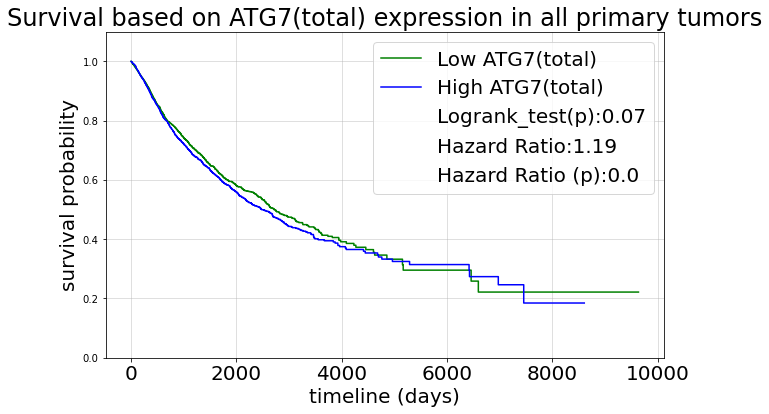

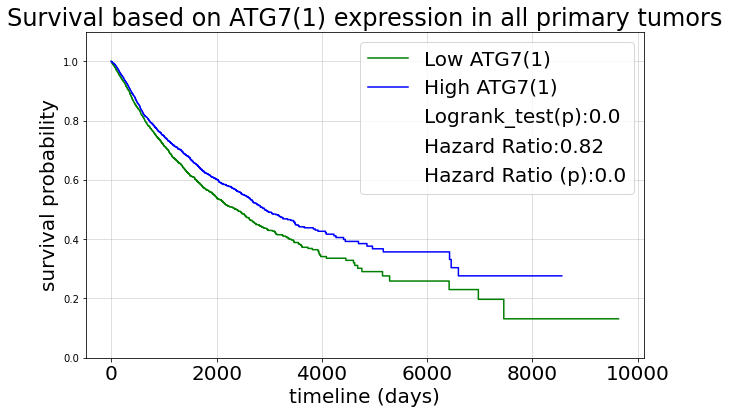

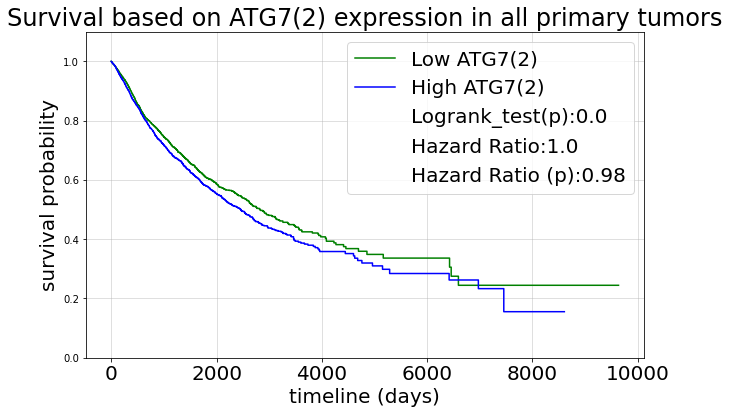

In [199]:
#KaplanMeier graph
all_data = [["ATG7(total)", 'ATG7', df_total_Low, df_total_High],
            ["ATG7(1)", 'ATG7_1', df_iso1_Low, df_iso1_High], 
            ["ATG7(2)", 'ATG7_2', df_iso2_Low, df_iso2_High]]

#Create survival table 
kmf = KaplanMeierFitter() 
tables_kmf = []

for data in all_data:
    
    #extraction of cph result (Hazard Ratio + pvalue)
    cph_atg7 = cph_results.loc[(cph_results['covariate'] == data[1])]
    hr_res = str(cph_atg7.loc[cph_atg7.index[0],'exp(coef)'].round(2))
    hr_pvalue_res = str(cph_atg7.loc[cph_atg7.index[0],'p'].round(2))
    
    
    # STATS_Log-Rank Test: Does ATG7 expression affect survival ?
    Time=data[2]['OS_time']
    Event=data[2]['OS']
    Time2=data[3]['OS_time']
    Event2=data[3]['OS']

    results = logrank_test(Time,Time2,event_observed_A=Event, event_observed_B=Event2)

    print("Results for ", data[0], 'in all primary tumors')
    
    #extract pvalue from logrank
    logrank_summary = results.summary
    logrank_res = str(logrank_summary.loc[logrank_summary.index[0], 'p'].round(2))
      
    ##Low expression
    kmf.fit(Time, Event, label = "Low_KM_estim")
    table_kmf_Low = kmf.survival_function_
    label1 = "Low "+ data[0]
    ##High expression
    kmf.fit(Time2, Event2, label = 'High_KM_estim')    
    table_kmf_High = kmf.survival_function_
    label2 = "High "+ data[0]

    #save data
    tables_kmf.append(table_kmf_Low)
    tables_kmf.append(table_kmf_High)
    
    #Kaplan Meier Plot
    plt.figure(figsize=(10,6))
    seaborn.lineplot(data=table_kmf_Low, x='timeline', y='Low_KM_estim', color = "green", drawstyle='steps-post', label = label1)
    seaborn.lineplot(data=table_kmf_High, x='timeline', y='High_KM_estim', color = "blue", drawstyle='steps-post', label = label2)
    seaborn.regplot(x=[],y=[], marker=" ", label= 'Logrank_test(p):'+ logrank_res)
    seaborn.regplot(x=[],y=[], marker=" ", label= 'Hazard Ratio:'+hr_res)
    seaborn.regplot(x=[],y=[], marker=" ", label= 'Hazard Ratio (p):'+hr_pvalue_res)
    
    plt.grid(alpha = 0.5)
    plt.legend()
    plt.ylim(0,1.1) 
    plt.xlabel('timeline (days)')
    plt.ylabel('survival probability')
    
    title_text = "Survival based on "+data[0]+ " expression in all primary tumors"
    plt.title(title_text)
    
    path = 'ATG7/all_tissue/figs_survival/'
    title_file = 'primary_kaplan_m_'+data[0]+'_alltissue.svg'
    plt.savefig(output_file_directory+path+title_file)

# 3] Survival for ratio ATG7(1) / ATG7(2)

## A) Data download

In [9]:
%%time
# DL data ATG7 isoform expression and High low expression separation
path = output_file_directory + "/ATG7/dataframes_for_input/"
df_ATG7_ratio1_2_LoHi_prim= pandas.read_csv(path+'df_ATG7_ratio1_2_LoHi_prim.tsv', sep = "\t")
df_ATG7_ratio2_1_LoHi_prim= pandas.read_csv(path+'df_ATG7_ratio2_1_LoHi_prim.tsv', sep = "\t")

print(df_ATG7_ratio2_1_LoHi_prim.shape)
df_ATG7_ratio2_1_LoHi_prim.head(3)

(9130, 25)
Wall time: 107 ms


,sample,Sample_Type,Primary_Site,L/H,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,...,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm,ratio_1_2,ratio_2_1
0,TCGA-P6-A5OG-01,Primary Tumor,Adrenal Gland,Low_iso2/iso1,1.0,383.0,4.790,4.056,1.151,-9.966,...,4.140146,1.686916,18.851948,88.225740,11.774261,-7.930814e-07,0.601220,0.080236,7.493102,0.133456
1,TCGA-OR-A5J8-01,Primary Tumor,Adrenal Gland,Low_iso2/iso1,1.0,579.0,4.764,4.570,-1.639,-9.966,...,4.629437,0.400624,24.071456,98.670297,1.329703,-6.211145e-07,0.874174,0.011781,74.204745,0.013476
2,TCGA-OR-A5K5-01,Primary Tumor,Adrenal Gland,Low_iso2/iso1,1.0,498.0,4.751,4.216,-2.727,-4.608,...,4.291540,0.201684,18.773186,98.987671,0.799224,2.131050e-01,0.690147,0.005572,123.854793,0.008074


In [10]:
#split to have low and High in different df
##iso1
df_ratio12_Low = df_ATG7_ratio1_2_LoHi_prim[df_ATG7_ratio1_2_LoHi_prim['L/H'].str.startswith('Low_iso1/iso2')]
df_ratio12_High = df_ATG7_ratio1_2_LoHi_prim[df_ATG7_ratio1_2_LoHi_prim['L/H'].str.startswith('High_iso1/iso2')]

##iso2
df_ratio21_Low = df_ATG7_ratio2_1_LoHi_prim[df_ATG7_ratio2_1_LoHi_prim['L/H'].str.startswith('Low_iso2/iso1')]
df_ratio21_High = df_ATG7_ratio2_1_LoHi_prim[df_ATG7_ratio2_1_LoHi_prim['L/H'].str.startswith('High_iso2/iso1')]
df_ratio21_High.head()

,sample,Sample_Type,Primary_Site,L/H,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,...,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm,ratio_1_2,ratio_2_1
4565,TCGA-OR-A5J2-01,Primary Tumor,Adrenal Gland,High_iso2/iso1,1.0,1677.0,4.824,3.239,1.903,1.2580,...,3.384104,2.244552,15.569935,60.632203,24.013593,15.354204,0.333301,0.132005,2.524912,0.396053
4566,TCGA-PA-A5YG-01,Primary Tumor,Adrenal Gland,High_iso2/iso1,0.0,756.0,4.600,3.060,2.783,1.1250,...,3.223226,2.978529,17.400563,47.922164,39.549417,12.528419,0.343858,0.283781,1.211703,0.825284
4567,TCGA-OR-A5JV-01,Primary Tumor,Adrenal Gland,High_iso2/iso1,0.0,2023.0,4.543,2.922,2.571,1.3620,...,3.100635,2.795188,16.088585,47.101474,36.928118,15.970408,0.325081,0.254867,1.275491,0.784012
4568,TCGA-OR-A5L8-01,Primary Tumor,Adrenal Gland,High_iso2/iso1,0.0,885.0,4.234,3.081,2.008,0.9862,...,3.241994,2.328044,14.462210,58.504250,27.805171,13.690579,0.449660,0.213709,2.104078,0.475268
4569,TCGA-OR-A5LP-01,Primary Tumor,Adrenal Gland,High_iso2/iso1,0.0,1857.0,4.058,2.501,2.118,0.6145,...,2.735474,2.416817,11.529721,49.088581,37.641131,13.270288,0.339817,0.260572,1.304121,0.766800


## B)  Log-Rank Test

In [11]:
# Log-Rank Test for Low Expression
## Define variables:
all_data = [["ratio 1/2:", df_ratio12_Low, df_ratio12_High], 
            ["ratio 2/1:", df_ratio21_Low, df_ratio21_High]]

for data in all_data:
    
    Time=data[1]['OS_time']
    Event=data[1]['OS']
    Time2=data[2]['OS_time']
    Event2=data[2]['OS']

    results = logrank_test(Time,Time2,event_observed_A=Event, event_observed_B=Event2)
    print("Results for ", data[0])
    results.print_summary()
    print()

Results for  ratio 1/2:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.96 0.33      1.61


Results for  ratio 2/1:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.70 0.03      5.05

## C)  CoxPHFitter

In [12]:
df_ATG7_ratio1_2_LoHi_prim.columns

Index(['sample', 'Sample_Type', 'Primary_Site', 'L/H', 'OS', 'OS_time', 'ATG7',
       'ATG7_1', 'ATG7_2', 'ATG7_3', 'ATG7_total', 'ATG7_1tpm', 'ATG7_2tpm',
       'ATG7_3tpm', 'log2_p1_ATG7_total', 'log2_p1_ATG7_1', 'log2_p1_ATG7_2',
       'ATG7_prot_tot', 'ATG7_1perc', 'ATG7_2perc', 'ATG7_3perc', 'ATG7_1norm',
       'ATG7_2norm', 'ratio_1_2', 'ratio_2_1'],
      dtype='object')

In [13]:
myselection = [i for i in range(4,6)]
add = [23,24]
myselection.extend(add)
myselection

df = df_ATG7_ratio1_2_LoHi_prim.iloc[:,myselection]
df.head()

,OS,OS_time,ratio_1_2,ratio_2_1
0,1.0,1677.0,2.524912,0.396053
1,0.0,756.0,1.211703,0.825284
2,0.0,2023.0,1.275491,0.784012
3,0.0,885.0,2.104078,0.475268
4,0.0,1857.0,1.304121,0.766800


In [205]:
myselection = [i for i in range(4,6)]
add = [24,23]
myselection.extend(add)
myselection

df = df_ATG7_ratio1_2_LoHi_prim.iloc[:,myselection]
df.head()

,OS,OS_time,ratio_1_2,ratio_2_1
0,1.0,1677.0,2.524912,0.396053
1,0.0,756.0,1.211703,0.825284
2,0.0,2023.0,1.275491,0.784012
3,0.0,885.0,2.104078,0.475268
4,0.0,1857.0,1.304121,0.766800


## Does it normal to have use difference between r1/2 and r2/1 ?

In [206]:
#CoxPHFitter
##Cox proportional hazard method is to notice, exp(coef) = HR
##how different factors in our dataset impact the event of interest

cph = CoxPHFitter()
cph.fit(df,'OS_time', 'OS')

cph_results = cph.summary
cph_results = cph_results[['exp(coef)', 'p']]
cph_results.reset_index(inplace= True)
cph_results

,covariate,exp(coef),p
0,ratio_1_2,1.000000,0.185759
1,ratio_2_1,1.199753,0.000030


## D)  Kaplan Meier

Results for  ratio ATG7(1)(2) in all primary tumors
Results for  ratio ATG7(2)(1) in all primary tumors


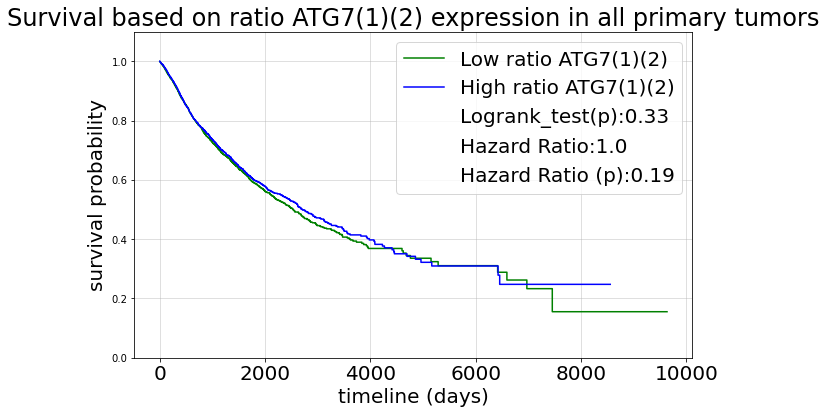

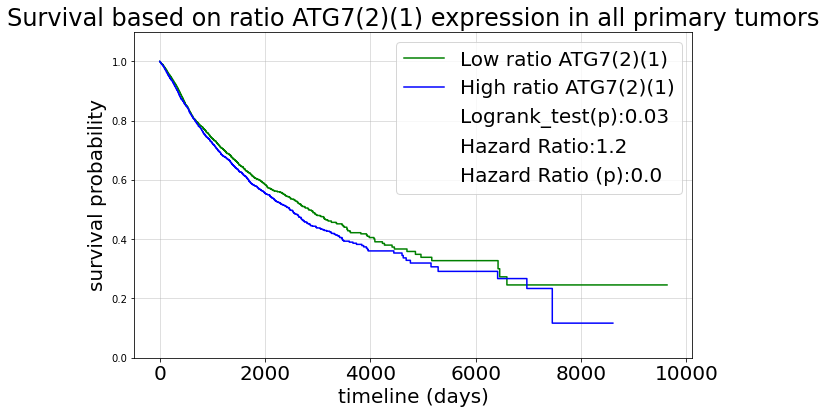

In [208]:
#KaplanMeier graph
all_data = [["ratio ATG7(1)(2)", 'ratio_1_2', df_ratio12_Low, df_ratio12_High],
            ["ratio ATG7(2)(1)", 'ratio_2_1', df_ratio21_Low, df_ratio21_High]]

#Create survival table 
kmf = KaplanMeierFitter() 
tables_kmf = []

for data in all_data:
    
    #extraction of cph result (Hazard Ratio + pvalue)
    cph_atg7 = cph_results.loc[(cph_results['covariate'] == data[1])]
    hr_res = str(cph_atg7.loc[cph_atg7.index[0],'exp(coef)'].round(2))
    hr_pvalue_res = str(cph_atg7.loc[cph_atg7.index[0],'p'].round(2))
    
    
    # STATS_Log-Rank Test: Does ATG7 expression affect survival ?
    Time=data[2]['OS_time']
    Event=data[2]['OS']
    Time2=data[3]['OS_time']
    Event2=data[3]['OS']

    results = logrank_test(Time,Time2,event_observed_A=Event, event_observed_B=Event2)

    print("Results for ", data[0], 'in all primary tumors')
    
    #extract pvalue from logrank
    logrank_summary = results.summary
    logrank_res = str(logrank_summary.loc[logrank_summary.index[0], 'p'].round(2))
      
    ##Low expression
    kmf.fit(Time, Event, label = "Low_KM_estim")
    table_kmf_Low = kmf.survival_function_
    label1 = "Low "+ data[0]
    ##High expression
    kmf.fit(Time2, Event2, label = 'High_KM_estim')    
    table_kmf_High = kmf.survival_function_
    label2 = "High "+ data[0]

    #save data
    tables_kmf.append(table_kmf_Low)
    tables_kmf.append(table_kmf_High)
    
    #Kaplan Meier Plot
    plt.figure(figsize=(10,6))
    seaborn.lineplot(data=table_kmf_Low, x='timeline', y='Low_KM_estim', color = "green", drawstyle='steps-post', label = label1)
    seaborn.lineplot(data=table_kmf_High, x='timeline', y='High_KM_estim', color = "blue", drawstyle='steps-post', label = label2)
    seaborn.regplot(x=[],y=[], marker=" ", label= 'Logrank_test(p):'+ logrank_res)
    seaborn.regplot(x=[],y=[], marker=" ", label= 'Hazard Ratio:'+hr_res)
    seaborn.regplot(x=[],y=[], marker=" ", label= 'Hazard Ratio (p):'+hr_pvalue_res)
    
    plt.grid(alpha = 0.5)
    plt.legend()
    plt.ylim(0,1.1) 
    plt.xlabel('timeline (days)')
    plt.ylabel('survival probability')
    
    title_text = "Survival based on "+data[0]+ " expression in all primary tumors"
    plt.title(title_text)
    
    path = 'ATG7/all_tissue/figs_survival/'
    title_file = 'primary_kaplan_m_'+data[0]+'_alltissue.svg'
    plt.savefig(output_file_directory+path+title_file)